Setup

In [1]:
import numpy as np
import pandas as pd
import os
from itertools import product
import scanpy as sc
import liana as li

import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# tight layout by default
plt.rcParams.update({'figure.autolayout': True})

from utils import *

In [2]:
li.__version__

'1.0.5'

In [3]:
path = os.path.join('..', '..', 'data', 'slidetags')

In [4]:
[method.method_name for method in li.mt.rank_aggregate.methods]

['CellPhoneDB', 'Connectome', 'log2FC', 'NATMI', 'SingleCellSignalR']

In [5]:
from liana.method import cellphonedb, connectome, cellchat, scseqcomm, singlecellsignalr, natmi, logfc, rank_aggregate, geometric_mean
methods = [cellphonedb, connectome, cellchat, scseqcomm, singlecellsignalr, natmi, logfc, rank_aggregate, geometric_mean]

In [6]:
groupby = 'cell_type'

In [7]:
d = {
     # 'SCP2162': 'mousehippocampus', # NOTE barcodes between metadata and matrix do not match; also very few spatially-matched
     'SCP2167': 'humancortex',
     'SCP2169': 'HumanTonsil',
     'SCP2170': 'mouseembryo',
     'SCP2171': 'HumanMelanomaRNA',
     'SCP2176': 'HumanMelanomaMultiome'
     }

Prep Data & Run LIANA

In [8]:
path

'../../data/slidetags'

In [9]:
for k, v in d.items():
    adata = sc.read_10x_mtx(os.path.join(path, f'{k}/expression/counts/'))
    spatial = pd.read_csv(os.path.join(path, f"{k}/cluster/{v}_spatial.csv")).iloc[1:].set_index("NAME")
    
    print(k, v, adata.shape)
    
    # NOTE: keep only cells that are in the spatial data
    adata = adata[adata.obs.index.isin(spatial.index)]
    adata.obs = adata.obs.merge(spatial, left_index=True, right_index=True)
    # remove _ from cell types
    adata.obs['cell_type'] = adata.obs['cell_type'].str.replace('_', '-')
    
    adata.obsm = {}
    adata.obsm['spatial'] = adata.obs[['X', 'Y']].values.astype(np.float32)
    
    # Filter and normalize
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    adata.layers['raw'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    if v.__contains__("mouse"):
        resource_name = 'mouseconsensus'
    else:
        resource_name = 'consensus'
    
    # Run Methods
    for method in methods:
        if method.method_name != 'Rank_Aggregate':
            kw = {'supp_columns': ['ligand_pvals', 'receptor_pvals']}
        else:
            kw = {}
        
        adata.uns[method.method_name] = method(adata,
                                               groupby=groupby,
                                               use_raw=False,
                                               verbose=False,
                                               n_perms=1000,
                                               n_jobs=10,
                                               inplace=False,
                                               resource_name = resource_name,
                                               **kw
                                               )
    
    adata.write_h5ad(os.path.join(path, k, "adata.h5ad"))

SCP2167 humancortex (14165, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2169 HumanTonsil (9360, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2170 mouseembryo (9037, 32285)


/home/dbdimitrov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/home/dbdimitrov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/home/dbdimitrov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

SCP2171 HumanMelanomaRNA (6466, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2176 HumanMelanomaMultiome (5704, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


Generate Truth

In [10]:
for k, v in d.items():
    adata = sc.read_h5ad(os.path.join(path, k, "adata.h5ad"))
    
    if v.__contains__("mouse"):
        resource_name = 'mouseconsensus'
    else:
        resource_name = 'consensus'
    
    # Run LR
    li.ut.spatial_neighbors(adata, bandwidth=150, cutoff=0.1, set_diag=True)
    li.mt.lr_bivar(adata, 
               function_name="morans",
               inplace=True,
               use_raw=False, 
               n_perms=0,
               expr_prop=0.05,
               verbose=True,
               mask_negatives=True,
               resource_name=resource_name
               )
    lrdata = adata.obsm['local_scores']
    lrdata.write_h5ad(os.path.join(path, k, "lrdata.h5ad"))
    
    # Run CP; NOTE: I'm currently discarding autocrine, and only evaluating para/ortho
    ctdata = onehot_groupby(adata, groupby='cell_type')
    interactions = list(product(ctdata.var.index, ctdata.var.index))
    
    li.mt.lr_bivar(ctdata, 
               function_name="morans",
               inplace=True,
               use_raw=False,
               expr_prop=0,
               n_perms=0,
               verbose=True,
               mask_negatives=True,
               interactions=interactions,
               )
    cpdata = ctdata.obsm['local_scores']
    cpdata.write_h5ad(os.path.join(path, k, "cpdata.h5ad"))

Using resource `consensus`.
Using `.X`!
... storing 'ligand' as categorical
... storing 'receptor' as categorical
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 7 self-interactions
... storing 'ligand' as categorical
... storing 'receptor' as categorical
Using resource `consensus`.
Using `.X`!
... storing 'ligand' as categorical
... storing 'receptor' as categorical
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 13 self-interactions
... storing 'ligand' as categorical
... storing 'receptor' as categorical
Using resource `mouseconsensus`.
Using `.X`!
... storing 'ligand' as categorica

Evaluate

In [11]:
from sklearn.metrics import f1_score

def calc_weighted_f1(gt, score_key):
    y_true, y_scores = gt['truth'], gt[score_key]

    weighted_f1 = f1_score(y_true, y_scores, average='weighted')
    
    return weighted_f1


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def calculate_metrics(gt, score_key, threshold=0.5):
    y_true, y_scores = gt['truth'], gt[score_key]

    # Convert probabilities to binary predictions using the specified threshold
    y_pred = (y_scores >= threshold).astype(int)

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred) # sensitivity

    return accuracy, precision, recall


In [113]:
# define custom filter functions
lambdas = {}
lambdas['CellPhoneDB'] = lambda x: x['cellphone_pvals'] < 0.05
lambdas['Connectome'] = lambda x: ((x['ligand_pvals'] < 0.05) & (x['receptor_pvals'] < 0.05) & (x['scaled_weight'] > 0))
lambdas['log2FC'] = lambda x: ((x['ligand_pvals'] < 0.05) & (x['receptor_pvals'] < 0.05) & (x['lr_logfc'] > 0))
# top 5% of ligand-receptor pairs
lambdas['NATMI'] = lambda x: ((x['spec_weight'] > np.quantile(gt['spec_weight'], 0.95))) # NOTE gt
lambdas['SingleCellSignalR'] = lambda x: (x['lrscore'] > 0.8)
lambdas['Rank_Aggregate'] = lambda x: (x['magnitude_rank'] < 0.05) # NOTE: try also Magnitude_rank
lambdas['Geometric Mean'] = lambda x: (x['gmean_pvals'] < 0.05)
lambdas['scSeqComm'] = lambda x: ((x['inter_score'] > np.quantile(gt['inter_score'], 0.95))) # NOTE gt
lambdas['CellChat'] = lambda x: ((x['cellchat_pvals'] < 0.05) & (x['ligand_pvals'] < 0.05) & (x['receptor_pvals'] < 0.05))

In [117]:
prop_range = [0.01, 0.05, 0.1, 0.2, 0.5]
eval_results = pd.DataFrame(columns=['Dataset', 'Method', 'Score', 'AUROC', 'Odds', 'AUPRC', "F1", "F1*"])
scores = li.mt.show_methods()

# Run Methods & Evaluate
for k, v in d.items():
    adata = sc.read_h5ad(os.path.join(path, f"{k}/adata.h5ad"))
    lrdata = sc.read_h5ad(os.path.join(path, f"{k}/lrdata.h5ad"))
    cpdata = sc.read_h5ad(os.path.join(path, f"{k}/cpdata.h5ad"))
    
    for method in methods:
        method_name = method.method_name        
        score_keys = scores[scores['Method Name'] == method.method_name]
        lr_res = adata.uns[method_name].copy()

        score_keys = score_keys[['Magnitude Score', 'Specificity Score']].values[0]
        # if None in score_keys, remove it
        score_keys = [s for s in score_keys if s is not None]
        
        gt = join_pred_truth(lr_res, lrdata, cpdata)
        gt['binary'] = gt.apply(lambdas[method_name], axis=1)
        f1 = calc_weighted_f1(gt, score_key='binary')

        for score_key in score_keys:
            gt = li.method.process_scores(gt, score_key=score_key)
            odds = [odds_ratio(gt, score_key=score_key, top_prop=prop) for prop in prop_range]
            auroc = calc_auroc(gt, score_key=score_key, show_plot=False)
            auprc = calc_auprc(gt, score_key=score_key, show_plot=False)
            
            # capped F1 - i.e. all scores are evaluated at the same threshold
            gt['cap'] = gt[score_key] >= np.quantile(gt[score_key], 0.95)
            f1_cap = calc_weighted_f1(gt, score_key='cap')
            
            # NOTE: f1 is calculated above - i.e. once per method
            eval_results.loc[len(eval_results)] = [v, method_name, score_key, auroc, odds, auprc, f1, f1_cap]

ratio: 0.12637190341799936, shape:(9567, 19)


In [101]:
eval_results.to_csv("evals_results.csv")

Visualize

In [102]:
res = pd.read_csv("evals_results.csv")
res.head()

,Unnamed: 0,Dataset,Method,Score,AUROC,Odds,AUPRC,F1,F1*
0,0,humancortex,CellPhoneDB,lr_means,0.535669,"[1.513939081053175, 1.603842722843615, 1.51192...",0.147440,0.561635,0.811339
1,1,humancortex,CellPhoneDB,cellphone_pvals,0.436628,"[0.0, 0.8748591031609899, 0.6320002685661619, ...",0.200850,0.561635,0.814704
2,2,humancortex,Connectome,expr_prod,0.525790,"[1.8576955424726662, 1.8263397156290715, 1.576...",0.145059,0.620465,0.813338
3,3,humancortex,Connectome,scaled_weight,0.561014,"[0.9994866684784249, 1.1975158808035944, 1.233...",0.146268,0.620465,0.806591
4,4,humancortex,CellChat,lr_probs,0.541922,"[1.8576955424726662, 1.8519209815718414, 1.563...",0.153096,0.768686,0.813588


In [103]:
# replace expr_prod with Product* when Method is Connectome
res.loc[(res['Score'] == 'expr_prod') & (res['Method'] == 'Connectome'), 'Score'] = 'Product*'
res.loc[(res['Score'] == 'expr_prod') & (res['Method'] == 'NATMI'), 'Score'] = 'Product✳'

# # filter Connectome when using Product*
# res = res[~((res['Score'] == 'Product*') & (res['Method'] == 'Connectome'))]

In [104]:
# Assuming 'res' is already loaded as a pandas DataFrame
# Replace underscores with spaces and title case 'Score'
res['Score'] = res['Score'].str.replace('_', ' ').str.title()

# Convert 'Score' to a categorical type with ordered categories
score_order = res.sort_values("Method")['Score'].unique()
res['Score'] = pd.Categorical(res['Score'], categories=score_order, ordered=True)

In [105]:
metric = "F1"

/tmp/ipykernel_1472994/233160233.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


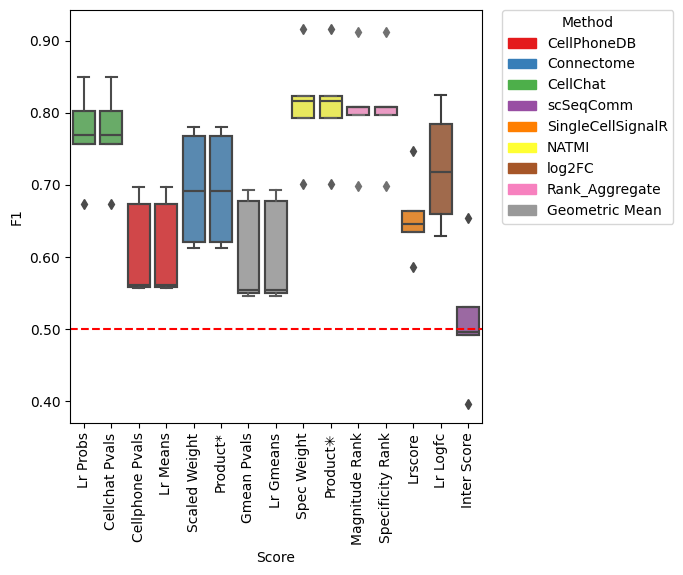

In [110]:
# Set the figure size
plt.figure(figsize=(7, 6))  # This is in inches

# Create a color palette
palette = sns.color_palette("Set1", n_colors=res['Method'].nunique())

# Plot each 'Method' group with a different color
for i, method in enumerate(res['Method'].unique()):
    subset = res[res['Method'] == method]
    sns.boxplot(x='Score', y=metric, data=subset, color=palette[i], boxprops=dict(alpha=.9))

# Plot the outlines without filling color
sns.boxplot(x='Score', y=metric, data=res, showcaps=False, boxprops=dict(facecolor='None'),
            showfliers=False, whiskerprops=dict(color='None'))

# Set the y-axis labels to two decimals
plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in plt.gca().get_yticks()])

# Draw a horizontal line at y=0.50
plt.axhline(y=0.50, color='red', linestyle='dashed', linewidth=1.5)

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Remove the title and subplot title
plt.title('')
plt.suptitle('')

method_names = res['Method'].unique()
colors = plt.cm.Set1(range(len(method_names)))

# Create a list of patches for the legend
legend_patches = [mpatches.Patch(color=colors[i], label=method) for i, method in enumerate(method_names)]
plt.legend(handles=legend_patches, title='Method', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Tight layout often improves the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [109]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming 'df' is your DataFrame, 'group' is the column with categorical group names, and 'value' is the column with the data
model = ols(f'{metric} ~ C(Score)', data=res).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
fvalue = anova_results['F'][0]
pvalue = anova_results['PR(>F)'][0]
anova_result_text = f'ANOVA Test: F={fvalue:.2f}, p={pvalue:.3e}'
anova_result_text

'ANOVA Test: F=8.17, p=2.171e-09'

In [108]:
res.drop_duplicates(subset=['Dataset', 'Method', 'Score']).drop("Unnamed: 0", axis=1)

,Dataset,Method,Score,AUROC,Odds,AUPRC,F1,F1*
0,humancortex,CellPhoneDB,Lr Means,0.535669,"[1.513939081053175, 1.603842722843615, 1.51192...",0.147440,0.561635,0.811339
1,humancortex,CellPhoneDB,Cellphone Pvals,0.436628,"[0.0, 0.8748591031609899, 0.6320002685661619, ...",0.200850,0.561635,0.814704
2,humancortex,Connectome,Product*,0.525790,"[1.8576955424726662, 1.8263397156290715, 1.576...",0.145059,0.620465,0.813338
3,humancortex,Connectome,Scaled Weight,0.561014,"[0.9994866684784249, 1.1975158808035944, 1.233...",0.146268,0.620465,0.806591
4,humancortex,CellChat,Lr Probs,0.541922,"[1.8576955424726662, 1.8519209815718414, 1.563...",0.153096,0.768686,0.813588
...,...,...,...,...,...,...,...,...
70,HumanMelanomaMultiome,log2FC,Lr Logfc,0.453451,"[1.6516536496985454, 0.9295181469094512, 0.807...",0.039054,0.825267,0.916217
71,HumanMelanomaMultiome,Rank_Aggregate,Magnitude Rank,0.495863,"[3.907046374740567, 1.3602461841771218, 1.1755...",0.152108,0.912710,0.938166
72,HumanMelanomaMultiome,Rank_Aggregate,Specificity Rank,0.505199,"[0.0, 0.44417630011096865, 0.613646670789528, ...",0.274951,0.912710,0.938166
73,HumanMelanomaMultiome,Geometric Mean,Lr Gmeans,0.498183,"[1.2984115167550274, 0.9065047710508571, 0.950...",0.042127,0.677796,0.916133


In [ ]:
# Rank AUPRC per dataset
res2 = res[['Dataset', 'Method', 'Score', 'F1']]
res2['rank'] = res2.groupby("Dataset")['F1'].rank(ascending=False, method='min')

/tmp/ipykernel_1380793/2049080445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
res2.groupby("Score")['rank'].mean().sort_values()

Score
Lr Probs             1.0
Spec Weight          1.4
Scaled Weight        4.2
Product*             4.4
Product✳             4.4
Lr Logfc             4.6
Cellchat Pvals       7.6
Specificity Rank     8.0
Magnitude Rank       8.2
Lr Gmeans            9.6
Lr Means            11.4
Cellphone Pvals     12.0
Gmean Pvals         12.6
Inter Score         14.0
Lrscore             15.0
Name: rank, dtype: float64

In [ ]:
?f1_score

Signature:
f1_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Docstring:
Compute the F1 score, also known as balanced F-score or F-measure.

The F1 score can be interpreted as a harmonic mean of the precision and
recall, where an F1 score reaches its best value at 1 and worst score at 0.
The relative contribution of precision and recall to the F1 score are
equal. The formula for the F1 score is::

    F1 = 2 * (precision * recall) / (precision + recall)

In the multi-class and multi-label case, this is the average of
the F1 score of each class with weighting depending on the ``average``
parameter.

Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

Parameters
----------
y_true : 1d array-like, or label indicator array / sparse matrix
    Ground truth (correct) target values.

y_pred : 1d array-like, or label indicator array / sparse matrix
    Estimated targets as re